# Integrating scCAT-seq cell lines

## Imports

In [1]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Maths
import pandas as pd
import numpy as np
import torch
from torch import optim
from umap import UMAP

In [3]:
# Our packages
from scmiot import models, pl, tl

In [4]:
import matplotlib.pyplot as plt

## Load data

In [5]:
mdata = mu.read_h5mu('../datasets/Liu/preprocessed/liu.h5mu.gz')
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

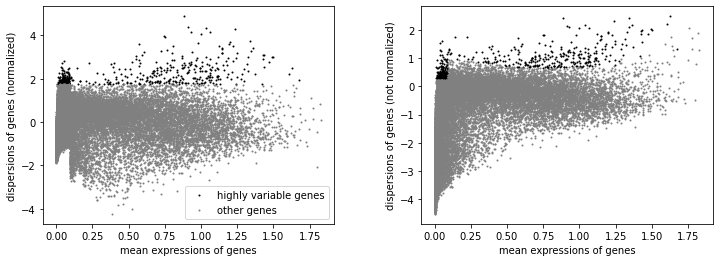

500

In [6]:
# Highly variable genes
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=500)
sc.pl.highly_variable_genes(rna)
np.sum(rna.var.highly_variable)

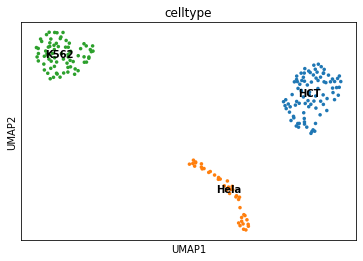

In [7]:
# Umap
sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=10)
sc.tl.umap(rna, spread=1.5, min_dist=.5)
sc.pl.umap(rna, color="celltype", legend_loc="on data", size=50)

## Preprocess ATAC

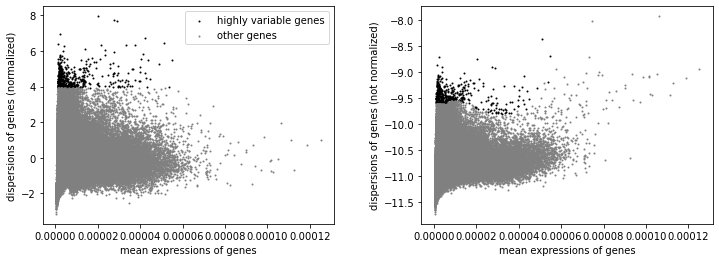

500

In [8]:
sc.pp.highly_variable_genes(atac, min_mean=1e-5, max_mean=4, min_disp=1, n_top_genes=500)
sc.pl.highly_variable_genes(atac)
np.sum(atac.var.highly_variable)

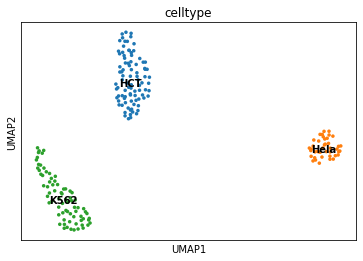

In [9]:
# Umap
sc.pp.scale(atac, zero_center=False)
sc.tl.pca(atac, svd_solver='arpack')
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=10)
sc.tl.umap(atac, spread=1.5, min_dist=.5)
sc.pl.umap(atac, color="celltype", legend_loc="on data", size=50)

## OT NMF

In [99]:
from importlib import reload

In [131]:
reload(models)

<module 'scmiot.models' from '/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scmiot/models.py'>

In [162]:
eps = .05
latent_dim = 10
rho_h = .05
rho_w = .05

In [163]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho_h, rho_w=rho_w, eps=eps, cost='cosine')

In [164]:
nmf.fit_transform(mdata, max_iter_inner=1_000, max_iter=100, device='cpu', dtype=torch.double, lr=1e-1, tol_inner=1e-4, tol_outer=1e-3)

 10%|█         | 20/200 [00:14<00:34,  5.23it/s, loss=-114.82897706259118]

## Convergence plots

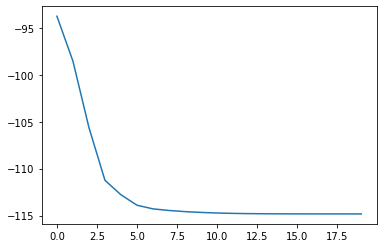

 10%|█         | 20/200 [00:15<02:18,  1.30it/s, loss=-114.82897706259118]


In [165]:
plt.plot(nmf.losses)

## Viz

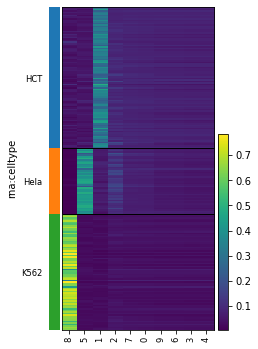

In [166]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

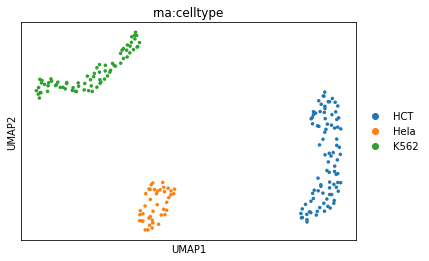

In [167]:
pl.umap(mdata, 'W_OT', 'rna:celltype')

## Automatically trim dimensions

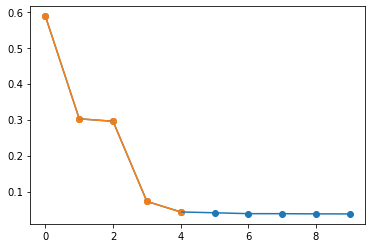

In [168]:
dims = tl.select_dimensions(mdata) # Inflexion point in variance, but at least 5 dimensions

In [169]:
tl.trim_dimensions(mdata, dims)

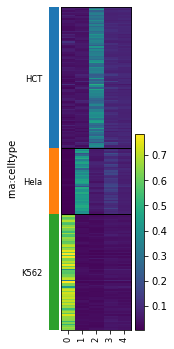

In [170]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

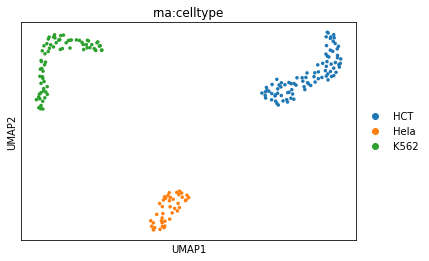

In [171]:
pl.umap(mdata, 'W_OT', 'rna:celltype')

## Variance explained

Influence of the omics and dimensions on the final reconstruction

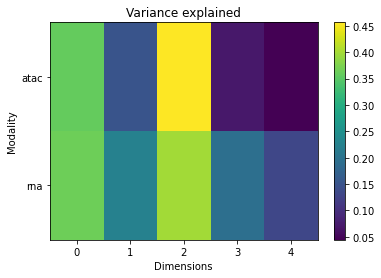

In [172]:
tl.variance_explained(mdata);

In [173]:
list(mdata.mod.keys())

['atac', 'rna']

## Clustering

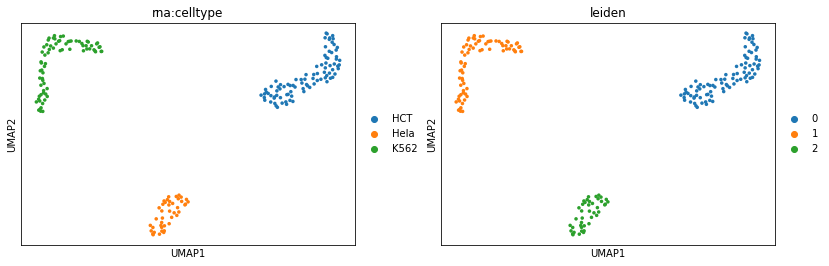

In [174]:
tl.leiden(mdata, resolution=.1)
pl.umap(mdata, 'W_OT', ['rna:celltype', 'leiden'])

## Clustering with automatic resolution

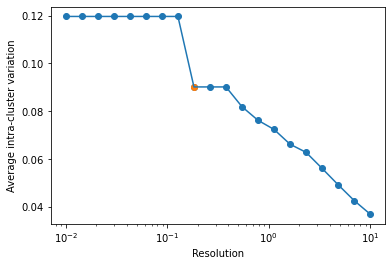

Leiden with best resolution heuristic (intra cluster variation elbow): 0.18329807108324356


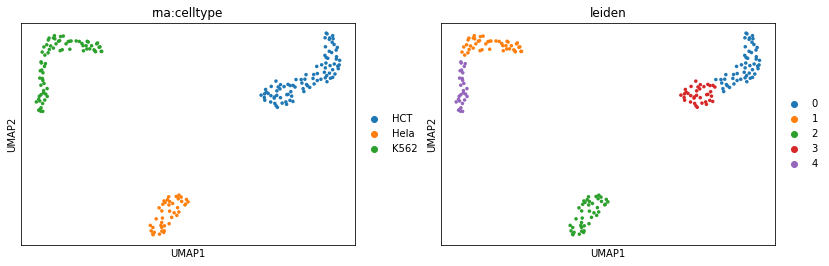

In [175]:
res = tl.best_leiden_resolution(mdata, method='elbow')
print('Leiden with best resolution heuristic (intra cluster variation elbow):', res)
tl.leiden(mdata, resolution=res)
pl.umap(mdata, 'W_OT', ['rna:celltype', 'leiden'])

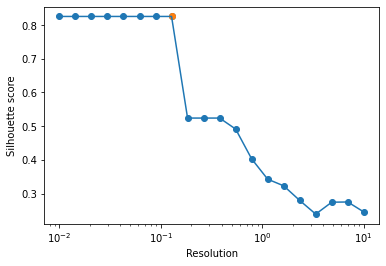

Leiden with best resolution heuristic (first local maximum silhouette): 0.12742749857031335


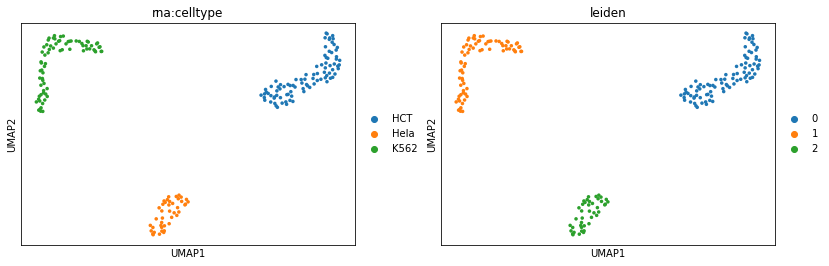

In [176]:
res = tl.best_leiden_resolution(mdata, method='silhouette')
print('Leiden with best resolution heuristic (first local maximum silhouette):', res)
tl.leiden(mdata, resolution=res)
pl.umap(mdata, 'W_OT', ['rna:celltype', 'leiden'])